In [7]:
import numpy as np
import pandas as pd
import os, re, time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import tensorflow as tf
from tensorflow import keras

In [37]:
from keras import layers
from keras.callbacks import TensorBoard

from keras.models import Sequential, Model

from keras.layers import LSTM, Dense, Dropout, Embedding, Input, Activation, GRU, Convolution1D, Flatten, LeakyReLU
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalAveragePooling1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import SpatialDropout1D, MaxPooling1D, Bidirectional, GRU, concatenate

from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

from keras.utils import pad_sequences

from collections import OrderedDict

from keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [9]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [10]:
from multiprocessing import cpu_count
print(cpu_count())

8


In [15]:
!mkdir -p /home/jupyter/data/wordvec/

In [42]:
mob = pd.read_csv("mobile_sent.csv")

In [43]:
mob['sentiment'].value_counts()

1    52197
0    17572
Name: sentiment, dtype: int64

In [44]:
mob.shape

(69769, 2)

In [45]:
#Column with clean text
textVar = mob["text"]

#Target columns (sentiment, class, etc.)
targetVar = mob["sentiment"]

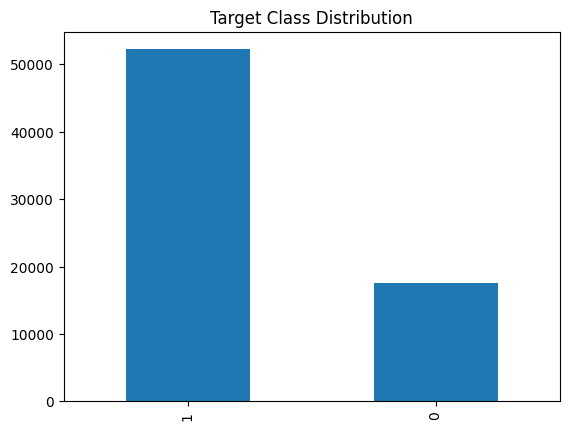

In [46]:
countClasses = pd.value_counts(targetVar.values, sort=True)
countClasses.plot.bar(legend=None, title="Target Class Distribution")
plt.show()

In [47]:
# make our experiments repeatable
np.random.seed(0)

# Model Hyperparameters
embedding_dim = 100

# Here we specify the number of units of our RNN layer
lstm_dims = 196

# Training parameters. Here we specify the training of the net will use N examples for each backprop iteration
batch_size = 64

# We will go thru the entire data set N times
num_epochs = 5

# Prepossessing parameters
# We will only input the first "sequence_length" words of every Yelp review (and pad out with nulls if the text is < "sequence_length
# We will also build our model using the most frequent 20000 words in our tweet 'dictionary'
sequence_length = 200
max_features = 20000

#Specify the number of classes to predict (1 for binary classification or count unique values for multilabel classification)
num_classes = 1
#num_classes = targetVar.nunique()

In [48]:
encoder = preprocessing.LabelEncoder()
encoder.fit(targetVar)

X = textVar.values
Y = encoder.transform(targetVar)

In [49]:
train_samples, val_samples, train_labels, val_labels = train_test_split(X,Y, stratify=targetVar, test_size = 0.33, random_state = 0)

In [50]:
# Check how many columns we have, make sure we have our sequence length set correctly

print(train_samples.shape,train_labels.shape)
print(val_samples.shape,val_labels.shape)

(46745,) (46745,)
(23024,) (23024,)


In [51]:
vectorizer = TextVectorization(max_tokens=max_features, output_sequence_length=sequence_length, ngrams=None, pad_to_max_tokens=True)

text_ds = tf.data.Dataset.from_tensor_slices(train_samples).batch(128)
vectorizer.adapt(text_ds)

In [52]:
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'the', 'i', 'it']

In [53]:
X_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
X_test = vectorizer(np.array([[s] for s in val_samples])).numpy()

Y_train = np.array(train_labels)
Y_test = np.array(val_labels)

#### Embeddings

In [54]:
embeddings_index = {}

glove_dir = '/home/jupyter/data/wordvec/'
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [55]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [56]:
num_tokens = len(voc) + 2
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 15211 words (4789 misses)


In [57]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

#### Model

In [58]:
sequence_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(sequence_input)

x = LSTM(lstm_dims, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(1, activation="sigmoid")(x)


model = Model(sequence_input, preds)
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 100)         2000200   
                                                                 
 lstm_layer (LSTM)           (None, None, 196)         232848    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 196)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 196)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                9850      
                                                             

In [60]:
filepath="/home/jupyter/data/dl_models/gru_glove_weights_best"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',
                             verbose=1, save_best_only=True, save_weights_only=False, overwrite=True, mode='max')
#only save model if it improves the accuracy

callbacks_list = [checkpoint]

t1 = time.time()
history = model.fit(X_train, Y_train,
                    batch_size=batch_size, 
                    epochs=num_epochs,
                    validation_data=(X_test, Y_test),
                    callbacks = callbacks_list,
                    verbose=1)
t2 = time.time()
print("GRU Glove model train time = %d seconds" %(t2-t1))

GRU_glove_history = history

Epoch 1/5


2023-05-24 23:28:10.549542: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


728/731 [============================>.] - ETA: 0s - loss: 0.1740 - accuracy: 0.9296
Epoch 1: val_accuracy improved from -inf to 0.95665, saving model to /home/jupyter/data/dl_models/gru_glove_weights_best


INFO:tensorflow:Assets written to: /home/jupyter/data/dl_models/gru_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/data/dl_models/gru_glove_weights_best/assets


731/731 [==============================] - 32s 40ms/step - loss: 0.1740 - accuracy: 0.9297 - val_loss: 0.1126 - val_accuracy: 0.9567
Epoch 2/5
730/731 [============================>.] - ETA: 0s - loss: 0.0895 - accuracy: 0.9676
Epoch 2: val_accuracy improved from 0.95665 to 0.97016, saving model to /home/jupyter/data/dl_models/gru_glove_weights_best


INFO:tensorflow:Assets written to: /home/jupyter/data/dl_models/gru_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/data/dl_models/gru_glove_weights_best/assets


731/731 [==============================] - 30s 41ms/step - loss: 0.0894 - accuracy: 0.9676 - val_loss: 0.0795 - val_accuracy: 0.9702
Epoch 3/5
729/731 [============================>.] - ETA: 0s - loss: 0.0711 - accuracy: 0.9748
Epoch 3: val_accuracy improved from 0.97016 to 0.97142, saving model to /home/jupyter/data/dl_models/gru_glove_weights_best


INFO:tensorflow:Assets written to: /home/jupyter/data/dl_models/gru_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/data/dl_models/gru_glove_weights_best/assets


731/731 [==============================] - 28s 38ms/step - loss: 0.0711 - accuracy: 0.9748 - val_loss: 0.0756 - val_accuracy: 0.9714
Epoch 4/5
731/731 [==============================] - ETA: 0s - loss: 0.0584 - accuracy: 0.9790
Epoch 4: val_accuracy improved from 0.97142 to 0.97437, saving model to /home/jupyter/data/dl_models/gru_glove_weights_best


INFO:tensorflow:Assets written to: /home/jupyter/data/dl_models/gru_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/data/dl_models/gru_glove_weights_best/assets


731/731 [==============================] - 30s 41ms/step - loss: 0.0584 - accuracy: 0.9790 - val_loss: 0.0710 - val_accuracy: 0.9744
Epoch 5/5
729/731 [============================>.] - ETA: 0s - loss: 0.0480 - accuracy: 0.9831
Epoch 5: val_accuracy did not improve from 0.97437
731/731 [==============================] - 12s 17ms/step - loss: 0.0480 - accuracy: 0.9831 - val_loss: 0.0766 - val_accuracy: 0.9724
GRU Glove model train time = 132 seconds


In [61]:
!ls -l "/home/jupyter/data/dl_models/gru_glove_weights_best"

total 101296
drwxr-xr-x 2 jupyter jupyter      4096 May 22 08:09 assets
-rw-r--r-- 1 jupyter jupyter 102903236 May 24 23:30 keras_metadata.pb
-rw-r--r-- 1 jupyter jupyter    811711 May 24 23:29 saved_model.pb
drwxr-xr-x 2 jupyter jupyter      4096 May 24 23:29 variables


In [62]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [63]:
def plot_train(history):
    """
    Plot the keras epoch results thru training
    """
    h = history.history
    epochs = range(1, len(h['accuracy']) + 1)
    plt.plot(epochs, h['accuracy'], 'go', label='Training acc')
    plt.plot(epochs, h['val_accuracy'], 'g', label='Validation acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

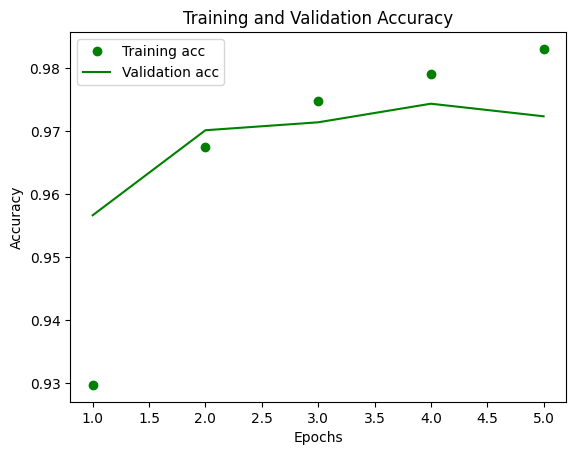

In [64]:
plot_train(GRU_glove_history)

In [65]:
def plot_loss(history):
    """
    Plot the keras epoch results thru training
    """
    h = history.history
    epochs = range(1, len(h['accuracy']) + 1)
    plt.plot(epochs, h['loss'], 'bo', label='Training loss')
    plt.plot(epochs, h['val_loss'], 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

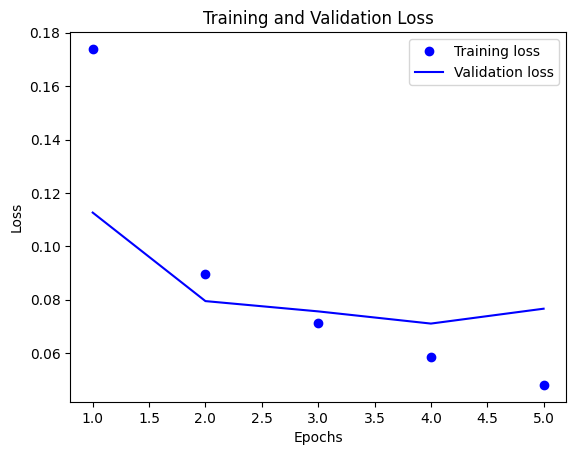

In [66]:
plot_loss(GRU_glove_history)